In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import seaborn as sns
import timedelta

plt.rcParams['font.family'] = 'Malgun Gothic'  # or 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
import numpy as np
from scipy.spatial import cKDTree
pd.set_option('display.max_columns', None)

## 산림 임상 데이터 불러오기

In [4]:
# data = gpd.read_file("./modified_geopackage/merged100_converted.gpkg")
# data = data.to_crs(epsg = 4326)
# data["centroids"] = data.geometry.centroid
# data

## 기상 관측 지점 데이터 불러오기

In [5]:
loc_df = pd.read_csv("./data/meta-loc-edited.csv", encoding='cp949')
loc_gdf = gpd.GeoDataFrame(
    loc_df, geometry=gpd.points_from_xy(loc_df.경도, loc_df.위도), crs="EPSG:4326"
)
loc_gdf.지점 = loc_gdf.지점.apply(str)

## 기상 관측 정보에 있는 지점들로 전처리 

In [ ]:
# 기상 관측 정보 불러오기 
weather = gpd.read_file("./data/whetherDataEH.csv", encoding='cp949')

In [ ]:
weather

,지점,지점명,일시,기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%),실효습도
0,12,안면도(감),2022-01-01 00:00,-4.5,34.0,2.6,0.0,59.0,17.700000000000003
1,12,안면도(감),2022-01-01 01:00,-4.6,37.8,2.4,0.0,58.0,29.790000000000003
2,12,안면도(감),2022-01-01 02:00,-5.0,62.6,2.7,0.0,65.0,31.680000000000003
3,12,안면도(감),2022-01-01 03:00,-5.0,68.4,2.9,0.0,54.0,29.850000000000005
4,12,안면도(감),2022-01-01 04:00,-4.9,65.6,2.7,0.0,51.0,26.640000000000004
...,...,...,...,...,...,...,...,...,...
16418967,996,화동,2024-12-31 19:00,-0.5,268.2,3.1,0.0,38.0,18.960000000000004
16418968,996,화동,2024-12-31 20:00,-0.8,266.5,3.8,0.0,38.0,19.380000000000003
16418969,996,화동,2024-12-31 21:00,-1.6,262.5,5.2,0.0,46.0,21.78
16418970,996,화동,2024-12-31 22:00,-2.4,263.6,3.9,0.0,55.0,26.16


In [ ]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16418972 entries, 0 to 16418971
Data columns (total 9 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   지점       object
 1   지점명      object
 2   일시       object
 3   기온(°C)   object
 4   풍향(deg)  object
 5   풍속(m/s)  object
 6   강수량(mm)  object
 7   습도(%)    object
 8   실효습도     object
dtypes: object(9)
memory usage: 1.1+ GB


In [ ]:
# 기상 관측 정보에 있는 지점들 찾기
loc_gdf_needed = loc_gdf[loc_gdf.지점.isin(weather.지점.unique())]
loc_gdf_needed

,지점,시작일,종료일,지점명,위도,경도,geometry
0,12,2007-11-30,NaN,안면도(감),36.5333,126.3167,POINT (126.3167 36.5333)
1,96,2020-10-23,NaN,독도,37.2395,131.8698,POINT (131.8698 37.2395)
2,116,2023-10-21,NaN,관악(레),37.4453,126.9640,POINT (126.964 37.4453)
4,160,2020-10-23,NaN,부산(레),35.1188,129.0000,POINT (129 35.1188)
5,175,2024-10-15,NaN,진도(레),34.4721,126.3238,POINT (126.3238 34.4721)
...,...,...,...,...,...,...,...
567,992,2021-11-10,NaN,하빈,35.9062,128.4464,POINT (128.4464 35.9062)
568,993,2024-04-06,NaN,제주금악,33.3423,126.3099,POINT (126.3099 33.3423)
569,994,2022-05-02,NaN,심포,35.8545,126.6421,POINT (126.6421 35.8545)
570,995,2023-12-19,NaN,오천,35.9286,129.3822,POINT (129.3822 35.9286)


In [ ]:
loc_gdf

,지점,시작일,종료일,지점명,위도,경도,geometry
0,12,2007-11-30,NaN,안면도(감),36.5333,126.3167,POINT (126.3167 36.5333)
1,96,2020-10-23,NaN,독도,37.2395,131.8698,POINT (131.8698 37.2395)
2,116,2023-10-21,NaN,관악(레),37.4453,126.9640,POINT (126.964 37.4453)
3,144,1993-03-16,2011-12-09,군산(레),36.0123,126.7834,POINT (126.7834 36.0123)
4,160,2020-10-23,NaN,부산(레),35.1188,129.0000,POINT (129 35.1188)
...,...,...,...,...,...,...,...
567,992,2021-11-10,NaN,하빈,35.9062,128.4464,POINT (128.4464 35.9062)
568,993,2024-04-06,NaN,제주금악,33.3423,126.3099,POINT (126.3099 33.3423)
569,994,2022-05-02,NaN,심포,35.8545,126.6421,POINT (126.6421 35.8545)
570,995,2023-12-19,NaN,오천,35.9286,129.3822,POINT (129.3822 35.9286)


In [ ]:
loc_array = loc_gdf['지점명'].unique()

# 관측 중단 후 시작된 지점 중복 데이터 제거됐는지 확인 (최신 관측소로 통일)

In [ ]:
# 지점 정보에 있는 중복 "지점명" 없음 
for i in loc_gdf_needed.지점명[loc_gdf_needed.지점명.duplicated() == True]:
    print(loc_gdf_needed[loc_gdf_needed.지점명 == i])

# weather data에서 빼야 할 강북*, 백아, 강진면 발견 

In [ ]:
# 강북*, 백아 위치 정보 필요 
for i in weather.지점명.unique():
    if i not in loc_gdf_needed.지점명.unique():
        print(i)

강북*
백아
강진면


# 행정구역 경계 정보 불러오기 

In [ ]:
bdd = gpd.read_file(f"./ctprvn/ctprvn.shp", encoding="euc-kr")
bdd.set_crs(epsg=5179, inplace=True)
bdd = bdd.to_crs(epsg=4326)

### 3가지 동시에 plot

<Axes: >

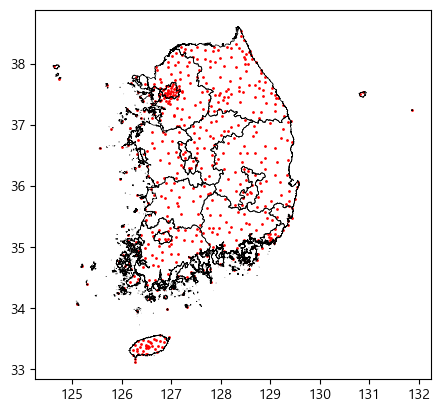

In [ ]:
ax = loc_gdf_needed.plot(markersize=1, color= "red")
bdd.boundary.plot(ax = ax, color = "black", linewidth = 0.5)

<Axes: >

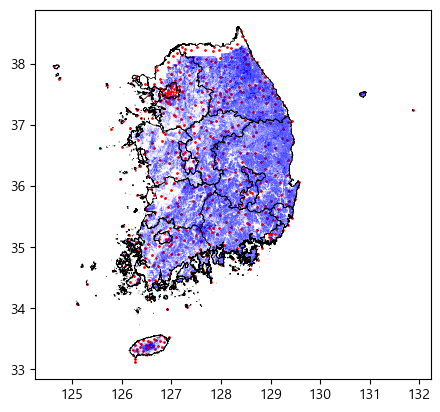

In [ ]:
ax = loc_gdf_needed.plot(markersize=1, color= "red")
bdd.boundary.plot(ax = ax, color = "black", linewidth = 0.5)
data.plot(ax = ax, color= "blue", markersize= 0.3)

### Frst마다 nearest 관측 지점 mapping

In [ ]:
# frst polygon마다 중심점으로 변환 
centroids = gpd.GeoDataFrame(data[["index", "centroids"]], geometry="centroids", crs=data.crs)
centroids

,index,centroids
0,0,POINT (126.92202 37.44349)
1,1,POINT (126.91649 37.4881)
2,2,POINT (126.9229 37.49214)
3,3,POINT (126.91419 37.45243)
4,4,POINT (126.92328 37.45185)
...,...,...
262843,501718,POINT (127.86934 35.9955)
262844,501719,POINT (127.86485 35.99106)
262845,501720,POINT (127.8712 35.98653)
262846,501721,POINT (127.87439 35.99678)


In [ ]:
# 가장 가까운 기상 관측 지점과 매핑 
nearest = gpd.sjoin_nearest(centroids, loc_gdf_needed[["geometry", "지점명"]], how="left", distance_col="distance")
nearest

c:\Users\sc.lee\miniconda3\envs\wildfire_env\Lib\site-packages\geopandas\array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


,index,centroids,index_right,지점명,distance
0,0,POINT (126.92202 37.44349),118,관악,0.029679
1,1,POINT (126.91649 37.4881),74,기상청,0.005298
2,2,POINT (126.9229 37.49214),74,기상청,0.005523
3,3,POINT (126.91419 37.45243),81,금천,0.019143
4,4,POINT (126.92328 37.45185),81,금천,0.026817
...,...,...,...,...,...
262843,501718,POINT (127.86934 35.9955),410,대덕,0.125225
262844,501719,POINT (127.86485 35.99106),410,대덕,0.127180
262845,501720,POINT (127.8712 35.98653),410,대덕,0.119488
262846,501721,POINT (127.87439 35.99678),410,대덕,0.121460


In [ ]:
# 각 지점으로부터 distance 분포 체크
nearest["distance"].describe()

count    262848.000000
mean          0.073497
std           0.035724
min           0.000174
25%           0.046354
50%           0.070883
75%           0.097395
max           0.219486
Name: distance, dtype: float64

<Axes: xlabel='distance'>

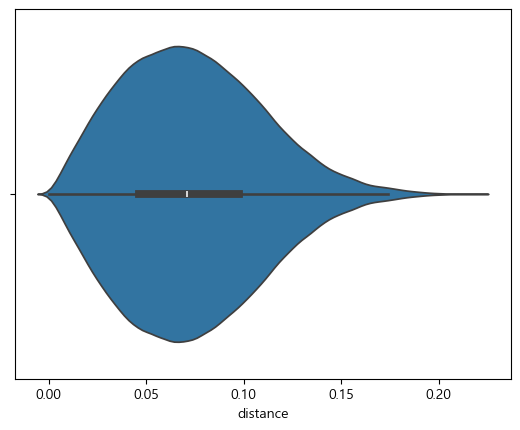

In [ ]:
# 평균인 0.07은 대략 7km 정도의 거리 
sns.violinplot(x=nearest["distance"])

### Merging Weather Observing Location with Forest Data

In [ ]:
full_data = (data.drop(columns=["centroids"])).merge(nearest.drop(columns=["centroids"]), on = "index", how = "left")
full_data

,index,FIFTH_FRTP,DMCLS_CD,AGCLS_CD,DNST_CD,frtp_CD,geometry,index_right,지점명,distance
0,0,H,2,4,B,활엽수림,"MULTIPOLYGON (((126.92156 37.44277, 126.92144 ...",118,관악,0.029679
1,1,H,2,4,B,활엽수림,"MULTIPOLYGON (((126.91631 37.48976, 126.91672 ...",74,기상청,0.005298
2,2,H,2,4,B,활엽수림,"MULTIPOLYGON (((126.92213 37.49274, 126.92385 ...",74,기상청,0.005523
3,3,H,2,5,B,활엽수림,"MULTIPOLYGON (((126.91117 37.45484, 126.91303 ...",81,금천,0.019143
4,4,H,2,5,B,활엽수림,"MULTIPOLYGON (((126.92227 37.45497, 126.92483 ...",81,금천,0.026817
...,...,...,...,...,...,...,...,...,...,...
262843,501718,Q,2,4,C,활엽수림,"MULTIPOLYGON (((127.86824 35.99774, 127.87158 ...",410,대덕,0.125225
262844,501719,Q,2,5,B,활엽수림,"MULTIPOLYGON (((127.8648 35.99199, 127.8671 35...",410,대덕,0.127180
262845,501720,Q,2,5,C,활엽수림,"MULTIPOLYGON (((127.87263 35.98754, 127.87137 ...",410,대덕,0.119488
262846,501721,Q,2,5,C,활엽수림,"MULTIPOLYGON (((127.875 35.99708, 127.875 35.9...",410,대덕,0.121460


In [ ]:
# 각 산림마다 가까운 기상 관측소 매핑.
full_data.to_file("weather_Loc&frst100.gpkg", driver="GPKG")

#### 산불 데이터 location Merge

## 산불 데이터 전처리 (이경헌 학우 전처리 코드 이용)

In [ ]:
sig_gdf = gpd.read_file("./sig/sig.shp", encoding='euc-kr')
sig_gdf.geometry = sig_gdf.geometry.set_crs('EPSG:5179')
sig_gdf.geometry = sig_gdf.geometry.to_crs('EPSG:4326')

emd_gdf = gpd.read_file("./emd/emd.shp", encoding='euc-kr')
emd_gdf.geometry = emd_gdf.geometry.set_crs('EPSG:5179')
emd_gdf.geometry = emd_gdf.geometry.to_crs('EPSG:4326')

In [ ]:
df = pd.read_csv('산불데이터에코드매핑.csv')
df

,발생일시_년,발생일시_월,발생일시_일,발생일시_시간,발생일시_요일,진화종료시간_년,진화종료시간_월,진화종료시간_일,진화종료시간_시간,발생장소_관서,발생장소_시도,발생장소_시군구,발생장소_읍면,발생장소_동리,발생원인_구분,발생원인_세부원인,발생원인_기타,피해면적_합계,발생장소_읍면동,발생장소_시도_시군구,발생장소_시도_시군구_읍면동,CTPRVN_CD,SIG_CD,EMD_CD,매핑수준,매핑방법
0,2024,9,29,15:41,일,2024,9,30,16:30,전북,전북,남원,산동,부절,기,작업장실화,산업현장실화,0.31,산동,전북 남원,전북 남원 산동,45,45190.0,45190410.0,완전 매칭,"시도,시군구,읍면동"
1,2024,9,10,15:55,화,2024,9,10,18:00,경남,경남,밀양,NaN,내이,기,기타(직접입력),성묘객실화(벌집소각),0.10,내이,경남 밀양,경남 밀양 내이,48,48270.0,48270102.0,완전 매칭,"시도,시군구,읍면동"
2,2024,9,10,14:35,화,2024,9,10,17:52,충남,충남,부여,규암,수목,기,기타(직접입력),원인미상,0.03,규암,충남 부여,충남 부여 규암,44,44760.0,44760310.0,완전 매칭,"시도,시군구,읍면동"
3,2024,9,10,14:24,화,2024,9,10,22:00,경북,경북,상주,화동,신촌,기,기타(직접입력),조사중,1.00,화동,경북 상주,경북 상주 화동,47,47250.0,47250400.0,완전 매칭,"시도,시군구,읍면동"
4,2024,9,5,13:51,목,2024,9,5,16:10,경북,경북,안동,녹전,매정,NaN,기타(직접입력),농산폐기물소각,0.05,녹전,경북 안동,경북 안동 녹전,47,47170.0,47170430.0,완전 매칭,"시도,시군구,읍면동"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1565,2022,1,3,12:36,월,2022,1,3,15:35,대구,대구,달성,옥포,반송,기,기타(직접입력),화목난로비화,0.08,옥포,대구 달성,대구 달성 옥포,27,27710.0,27710262.0,완전 매칭,"시도,시군구,읍면동"
1566,2022,1,3,12:02,월,2022,1,3,14:56,강원,강원,인제,남,수산,기,기타(직접입력),화목보일러재투기,0.80,남,강원 인제,강원 인제 남,51,51810.0,51810310.0,완전 매칭,"시도,시군구,읍면동"
1567,2022,1,2,14:29,일,2022,1,2,16:50,전남,전남,보성,조성,귀산,담,담뱃불실화,담뱃불실화,0.10,조성,전남 보성,전남 보성 조성,46,46780.0,46780370.0,완전 매칭,"시도,시군구,읍면동"
1568,2022,1,2,08:18,일,2022,1,2,12:50,경북,대구,군위,부계,신화,NaN,주택화재비화,축사전기누전,0.20,부계,대구 군위,대구 군위 부계,27,27720.0,27720330.0,완전 매칭,"시도,시군구,읍면동"


In [ ]:
df['SIG_CD'] = df['SIG_CD'].apply(lambda x: f'{x:.0f}')
df['EMD_CD'] = df['EMD_CD'].apply(lambda x: f'{x:.0f}')
df = df[(df['SIG_CD'] != "nan") & (df['EMD_CD'] != "nan")]
sig_rep_pts = dict(zip(sig_gdf['SIG_CD'], sig_gdf.geometry.apply(lambda x: x.representative_point())))
emd_rep_pts = dict(zip(emd_gdf['EMD_CD'], emd_gdf.geometry.apply(lambda x: x.representative_point())))

In [ ]:
df['REP_COORD'] = df['EMD_CD'].map(emd_rep_pts)
df.loc[df['REP_COORD'].isna(), 'REP_COORD'] =  df.loc[df['REP_COORD'].isna(), 'SIG_CD'].map(sig_rep_pts)
assert df['REP_COORD'].isna().sum() == 0


C:\Users\sc.lee\AppData\Local\Temp\ipykernel_30620\44222218.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['REP_COORD'] = df['EMD_CD'].map(emd_rep_pts)


##### 산불 데이터 추가 전처리 

In [ ]:
fire_gdf = gpd.GeoDataFrame(
    df, geometry= "REP_COORD", crs="EPSG:4326"
)
fire_gdf

,발생일시_년,발생일시_월,발생일시_일,발생일시_시간,발생일시_요일,진화종료시간_년,진화종료시간_월,진화종료시간_일,진화종료시간_시간,발생장소_관서,발생장소_시도,발생장소_시군구,발생장소_읍면,발생장소_동리,발생원인_구분,발생원인_세부원인,발생원인_기타,피해면적_합계,발생장소_읍면동,발생장소_시도_시군구,발생장소_시도_시군구_읍면동,CTPRVN_CD,SIG_CD,EMD_CD,매핑수준,매핑방법,REP_COORD
0,2024,9,29,15:41,일,2024,9,30,16:30,전북,전북,남원,산동,부절,기,작업장실화,산업현장실화,0.31,산동,전북 남원,전북 남원 산동,45,45190,45190410,완전 매칭,"시도,시군구,읍면동",POINT (127.48083 35.50199)
1,2024,9,10,15:55,화,2024,9,10,18:00,경남,경남,밀양,NaN,내이,기,기타(직접입력),성묘객실화(벌집소각),0.10,내이,경남 밀양,경남 밀양 내이,48,48270,48270102,완전 매칭,"시도,시군구,읍면동",POINT (128.74364 35.497)
2,2024,9,10,14:35,화,2024,9,10,17:52,충남,충남,부여,규암,수목,기,기타(직접입력),원인미상,0.03,규암,충남 부여,충남 부여 규암,44,44760,44760310,완전 매칭,"시도,시군구,읍면동",POINT (126.86571 36.28309)
3,2024,9,10,14:24,화,2024,9,10,22:00,경북,경북,상주,화동,신촌,기,기타(직접입력),조사중,1.00,화동,경북 상주,경북 상주 화동,47,47250,47250400,완전 매칭,"시도,시군구,읍면동",POINT (127.97244 36.398)
4,2024,9,5,13:51,목,2024,9,5,16:10,경북,경북,안동,녹전,매정,NaN,기타(직접입력),농산폐기물소각,0.05,녹전,경북 안동,경북 안동 녹전,47,47170,47170430,완전 매칭,"시도,시군구,읍면동",POINT (128.76731 36.75129)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1565,2022,1,3,12:36,월,2022,1,3,15:35,대구,대구,달성,옥포,반송,기,기타(직접입력),화목난로비화,0.08,옥포,대구 달성,대구 달성 옥포,27,27710,27710262,완전 매칭,"시도,시군구,읍면동",POINT (128.48786 35.76543)
1566,2022,1,3,12:02,월,2022,1,3,14:56,강원,강원,인제,남,수산,기,기타(직접입력),화목보일러재투기,0.80,남,강원 인제,강원 인제 남,51,51810,51810310,완전 매칭,"시도,시군구,읍면동",POINT (128.10488 37.9979)
1567,2022,1,2,14:29,일,2022,1,2,16:50,전남,전남,보성,조성,귀산,담,담뱃불실화,담뱃불실화,0.10,조성,전남 보성,전남 보성 조성,46,46780,46780370,완전 매칭,"시도,시군구,읍면동",POINT (127.24196 34.80107)
1568,2022,1,2,08:18,일,2022,1,2,12:50,경북,대구,군위,부계,신화,NaN,주택화재비화,축사전기누전,0.20,부계,대구 군위,대구 군위 부계,27,27720,27720330,완전 매칭,"시도,시군구,읍면동",POINT (128.6619 36.06617)


<Axes: >

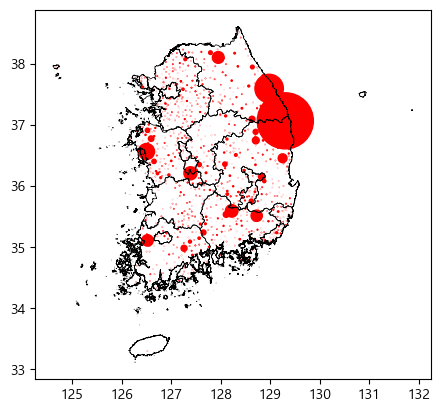

In [ ]:
fir = fire_gdf.plot(markersize = fire_gdf.피해면적_합계/10, color = "red")
bdd.boundary.plot(ax = fir, color = "black", linewidth = 0.5)

In [ ]:
# 추가로 이상값 발견 1
# 진화 종료 년도 입력 오류 
fire_gdf.loc[227]

발생일시_년                                                     2023
발생일시_월                                                       12
발생일시_일                                                       27
발생일시_시간                                                   14:57
발생일시_요일                                                       수
진화종료시간_년                                                   2223
진화종료시간_월                                                     12
진화종료시간_일                                                     27
진화종료시간_시간                                                 18:00
발생장소_관서                                                      경남
발생장소_시도                                                      경남
발생장소_시군구                                                     밀양
발생장소_읍면                                                     삼랑진
발생장소_동리                                                      행곡
발생원인_구분                                                     NaN
발생원인_세부원인                               

In [ ]:
# 추가로 이상값 발견 2
# 진화 종료 시간 오류 입력
fire_gdf.loc[[998, 717, 968, 969, 999, 1159, 1271, 1286, 1339, 1417, 1516]]

,발생일시_년,발생일시_월,발생일시_일,발생일시_시간,발생일시_요일,진화종료시간_년,진화종료시간_월,진화종료시간_일,진화종료시간_시간,발생장소_관서,발생장소_시도,발생장소_시군구,발생장소_읍면,발생장소_동리,발생원인_구분,발생원인_세부원인,발생원인_기타,피해면적_합계,발생장소_읍면동,발생장소_시도_시군구,발생장소_시도_시군구_읍면동,CTPRVN_CD,SIG_CD,EMD_CD,매핑수준,매핑방법,REP_COORD
998,2022,5,22,22:54,일,2022,5,22,00:00,부산,부산,사상,NaN,괘법,기,기타(직접입력),조사중,0.02,괘법,부산 사상,부산 사상 괘법,26,26530,26530104,완전 매칭,"시도,시군구,읍면동",POINT (128.99179 35.16677)
717,2023,2,24,14:20,금,2023,2,24,00:00,부산,부산,기장,정관,병산,담,기타(직접입력),담뱃불실화,3.00,정관,부산 기장,부산 기장 정관,26,26710,26710256,완전 매칭,"시도,시군구,읍면동",POINT (129.17156 35.34029)
968,2022,5,29,22:25,일,2022,5,29,00:00,경남,경남,거제,하청,덕곡,기,기타(직접입력),아궁아불씨부주의,0.20,하청,경남 거제,경남 거제 하청,48,48310,48310380,완전 매칭,"시도,시군구,읍면동",POINT (128.63588 34.95725)
969,2022,5,29,22:15,일,2022,5,29,00:00,전북,전북,진안,마령,계서,기,기타(직접입력),화목보일러추정,0.20,마령,전북 진안,전북 진안 마령,45,45720,45720370,완전 매칭,"시도,시군구,읍면동",POINT (127.36998 35.74056)
999,2022,5,22,18:28,일,2022,5,22,00:00,남부,경남,김해,NaN,구산,입,기타(직접입력),입산자실화추정,1.00,구산,경남 김해,경남 김해 구산,48,48250,48250106,완전 매칭,"시도,시군구,읍면동",POINT (128.87469 35.24966)
1159,2022,4,11,18:34,월,2022,4,11,00:00,울산,울산,울주,두서,내와,NaN,주택화재비화,주택화재비화,0.50,두서,울산 울주,울산 울주 두서,31,31710,31710370,완전 매칭,"시도,시군구,읍면동",POINT (129.14437 35.66717)
1271,2022,3,12,14:09,토,2022,3,12,00:00,북부,강원,홍천,서석,생곡,쓰,쓰레기소각,생활쓰레기소각,8.00,서석,강원 홍천,강원 홍천 서석,51,51720,51720340,완전 매칭,"시도,시군구,읍면동",POINT (128.2201 37.7278)
1286,2022,3,9,20:07,수,2022,3,9,00:00,울산,울산,북,NaN,천곡,기,기타(직접입력),미상,1.00,천곡,울산 북,울산 북 천곡,31,31200,31200108,완전 매칭,"시도,시군구,읍면동",POINT (129.32233 35.64934)
1339,2022,2,28,20:18,월,2022,2,28,00:00,경북,경북,안동,NaN,정상,입,기타(직접입력),입산자실화,0.67,정상,경북 안동,경북 안동 정상,47,47170,47170139,완전 매칭,"시도,시군구,읍면동",POINT (128.75268 36.54334)
1417,2022,2,18,19:34,금,2022,2,18,00:00,전남,전남,여수,NaN,오림,입,기타(직접입력),입산자실화,0.30,오림,전남 여수,전남 여수 오림,46,46130,46130121,완전 매칭,"시도,시군구,읍면동",POINT (127.7168 34.75915)


In [ ]:
# 이상값 처리 
fire_gdf.loc[227, "진화종료시간_년"] = 2023
fire_gdf.loc[[998, 717, 968, 969, 999, 1159, 1271, 1286, 1339, 1417, 1516], "진화종료시간_시간"] = "23:59"

In [ ]:
fire_gdf.loc[[998, 717, 968, 969, 999, 1159, 1271, 1286, 1339, 1417, 1516]]

,발생일시_년,발생일시_월,발생일시_일,발생일시_시간,발생일시_요일,진화종료시간_년,진화종료시간_월,진화종료시간_일,진화종료시간_시간,발생장소_관서,발생장소_시도,발생장소_시군구,발생장소_읍면,발생장소_동리,발생원인_구분,발생원인_세부원인,발생원인_기타,피해면적_합계,발생장소_읍면동,발생장소_시도_시군구,발생장소_시도_시군구_읍면동,CTPRVN_CD,SIG_CD,EMD_CD,매핑수준,매핑방법,REP_COORD
998,2022,5,22,22:54,일,2022,5,22,23:59,부산,부산,사상,NaN,괘법,기,기타(직접입력),조사중,0.02,괘법,부산 사상,부산 사상 괘법,26,26530,26530104,완전 매칭,"시도,시군구,읍면동",POINT (128.99179 35.16677)
717,2023,2,24,14:20,금,2023,2,24,23:59,부산,부산,기장,정관,병산,담,기타(직접입력),담뱃불실화,3.00,정관,부산 기장,부산 기장 정관,26,26710,26710256,완전 매칭,"시도,시군구,읍면동",POINT (129.17156 35.34029)
968,2022,5,29,22:25,일,2022,5,29,23:59,경남,경남,거제,하청,덕곡,기,기타(직접입력),아궁아불씨부주의,0.20,하청,경남 거제,경남 거제 하청,48,48310,48310380,완전 매칭,"시도,시군구,읍면동",POINT (128.63588 34.95725)
969,2022,5,29,22:15,일,2022,5,29,23:59,전북,전북,진안,마령,계서,기,기타(직접입력),화목보일러추정,0.20,마령,전북 진안,전북 진안 마령,45,45720,45720370,완전 매칭,"시도,시군구,읍면동",POINT (127.36998 35.74056)
999,2022,5,22,18:28,일,2022,5,22,23:59,남부,경남,김해,NaN,구산,입,기타(직접입력),입산자실화추정,1.00,구산,경남 김해,경남 김해 구산,48,48250,48250106,완전 매칭,"시도,시군구,읍면동",POINT (128.87469 35.24966)
1159,2022,4,11,18:34,월,2022,4,11,23:59,울산,울산,울주,두서,내와,NaN,주택화재비화,주택화재비화,0.50,두서,울산 울주,울산 울주 두서,31,31710,31710370,완전 매칭,"시도,시군구,읍면동",POINT (129.14437 35.66717)
1271,2022,3,12,14:09,토,2022,3,12,23:59,북부,강원,홍천,서석,생곡,쓰,쓰레기소각,생활쓰레기소각,8.00,서석,강원 홍천,강원 홍천 서석,51,51720,51720340,완전 매칭,"시도,시군구,읍면동",POINT (128.2201 37.7278)
1286,2022,3,9,20:07,수,2022,3,9,23:59,울산,울산,북,NaN,천곡,기,기타(직접입력),미상,1.00,천곡,울산 북,울산 북 천곡,31,31200,31200108,완전 매칭,"시도,시군구,읍면동",POINT (129.32233 35.64934)
1339,2022,2,28,20:18,월,2022,2,28,23:59,경북,경북,안동,NaN,정상,입,기타(직접입력),입산자실화,0.67,정상,경북 안동,경북 안동 정상,47,47170,47170139,완전 매칭,"시도,시군구,읍면동",POINT (128.75268 36.54334)
1417,2022,2,18,19:34,금,2022,2,18,23:59,전남,전남,여수,NaN,오림,입,기타(직접입력),입산자실화,0.30,오림,전남 여수,전남 여수 오림,46,46130,46130121,완전 매칭,"시도,시군구,읍면동",POINT (127.7168 34.75915)


In [ ]:
#['발생일시_년', '발생일시_월', '발생일시_일', '발생일시_시간']
fire_gdf["발생일시"] = pd.to_datetime(
    fire_gdf["발생일시_년"].astype(str) + "-" +
    fire_gdf["발생일시_월"].astype(str).str.zfill(2) + "-" +
    fire_gdf["발생일시_일"].astype(str).str.zfill(2) + " " +
    fire_gdf["발생일시_시간"]
)

fire_gdf["진화일시"] = pd.to_datetime(
    fire_gdf["진화종료시간_년"].astype(str) + "-" +
    fire_gdf["진화종료시간_월"].astype(str).str.zfill(2) + "-" +
    fire_gdf["진화종료시간_일"].astype(str).str.zfill(2) + " " +
    fire_gdf["진화종료시간_시간"]
)

fire_gdf.drop(columns=['발생일시_년', '발생일시_월', '발생일시_일', '발생일시_시간','발생일시_요일', '진화종료시간_년','진화종료시간_월', '진화종료시간_일', '진화종료시간_시간'], inplace= True)
fire_gdf["duration"] = (fire_gdf.진화일시 - fire_gdf.발생일시).dt.total_seconds() / 3600

In [ ]:
fire_gdf.head()

,발생장소_관서,발생장소_시도,발생장소_시군구,발생장소_읍면,발생장소_동리,발생원인_구분,발생원인_세부원인,발생원인_기타,피해면적_합계,발생장소_읍면동,발생장소_시도_시군구,발생장소_시도_시군구_읍면동,CTPRVN_CD,SIG_CD,EMD_CD,매핑수준,매핑방법,REP_COORD,발생일시,진화일시,duration
0,전북,전북,남원,산동,부절,기,작업장실화,산업현장실화,0.31,산동,전북 남원,전북 남원 산동,45,45190,45190410,완전 매칭,"시도,시군구,읍면동",POINT (127.48083 35.50199),2024-09-29 15:41:00,2024-09-30 16:30:00,24.816667
1,경남,경남,밀양,NaN,내이,기,기타(직접입력),성묘객실화(벌집소각),0.10,내이,경남 밀양,경남 밀양 내이,48,48270,48270102,완전 매칭,"시도,시군구,읍면동",POINT (128.74364 35.497),2024-09-10 15:55:00,2024-09-10 18:00:00,2.083333
2,충남,충남,부여,규암,수목,기,기타(직접입력),원인미상,0.03,규암,충남 부여,충남 부여 규암,44,44760,44760310,완전 매칭,"시도,시군구,읍면동",POINT (126.86571 36.28309),2024-09-10 14:35:00,2024-09-10 17:52:00,3.283333
3,경북,경북,상주,화동,신촌,기,기타(직접입력),조사중,1.00,화동,경북 상주,경북 상주 화동,47,47250,47250400,완전 매칭,"시도,시군구,읍면동",POINT (127.97244 36.398),2024-09-10 14:24:00,2024-09-10 22:00:00,7.600000
4,경북,경북,안동,녹전,매정,NaN,기타(직접입력),농산폐기물소각,0.05,녹전,경북 안동,경북 안동 녹전,47,47170,47170430,완전 매칭,"시도,시군구,읍면동",POINT (128.76731 36.75129),2024-09-05 13:51:00,2024-09-05 16:10:00,2.316667


In [ ]:
fire_gdf.index[fire_gdf.duration<0]

Index([], dtype='int64')

<Axes: xlabel='duration', ylabel='피해면적_합계'>

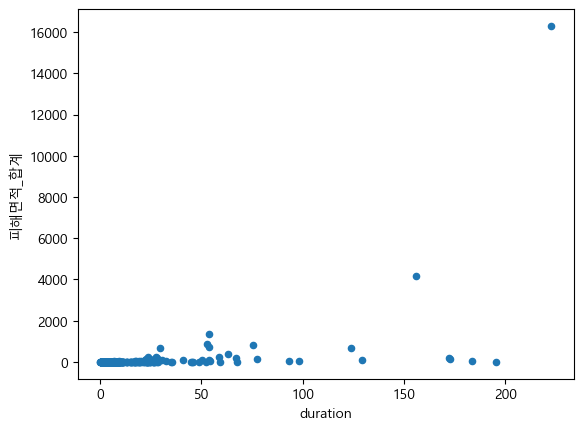

In [ ]:
fire_gdf.plot.scatter(x = "duration", y="피해면적_합계")

In [ ]:
fire_gdf[fire_gdf.duration>150]

,발생장소_관서,발생장소_시도,발생장소_시군구,발생장소_읍면,발생장소_동리,발생원인_구분,발생원인_세부원인,발생원인_기타,피해면적_합계,발생장소_읍면동,발생장소_시도_시군구,발생장소_시도_시군구_읍면동,CTPRVN_CD,SIG_CD,EMD_CD,매핑수준,매핑방법,REP_COORD,발생일시,진화일시,duration
1226,경북,경북,봉화,봉화,화천,기,기타(직접입력),화목보일러재투기,130.00,봉화,경북 봉화,경북 봉화 봉화,47,47920,47920250,완전 매칭,"시도,시군구,읍면동",POINT (128.70331 36.88937),2022-04-05 13:29:00,2022-04-12 18:00:00,172.516667
1308,대구,대구,달성,가창,오,기,기타(직접입력),산불비화추정,22.96,가창,대구 달성,대구 달성 가창,27,27710,27710310,완전 매칭,"시도,시군구,읍면동",POINT (128.61725 35.75567),2022-03-05 19:15:00,2022-03-13 11:00:00,183.750000
1318,강원,강원,강릉,옥계,남양,기,방화,방화,4190.38,옥계,강원 강릉,강원 강릉 옥계,51,51150,51150350,완전 매칭,"시도,시군구,읍면동",POINT (128.9765 37.59884),2022-03-05 01:08:00,2022-03-11 13:00:00,155.866667
1325,강원,강원,영월,김삿갓,외룡,기,기타(직접입력),화목보일러불씨,184.01,김삿갓,강원 영월,강원 영월 김삿갓,51,51750,51750325,완전 매칭,"시도,시군구,읍면동",POINT (128.63086 37.09619),2022-03-04 12:45:00,2022-03-11 17:00:00,172.250000
1326,경북,경북,울진,북,두천,기,기타(직접입력),도로변발화추정,16301.98,북,경북 울진,경북 울진 북,47,47930,47930310,완전 매칭,"시도,시군구,읍면동",POINT (129.30298 37.06908),2022-03-04 11:17:00,2022-03-13 18:00:00,222.716667
1336,남부,부산,금정,NaN,회동,기,기타(직접입력),미상,20.00,회동,부산 금정,부산 금정 회동,26,26410,26410112,완전 매칭,"시도,시군구,읍면동",POINT (129.12794 35.23911),2022-03-02 14:43:00,2022-03-10 18:00:00,195.283333


In [ ]:
fire_gdf.to_file("fire_clean.gpkg", driver="GPKG")

# 데이터 열어보기

In [ ]:
fire_data = gpd.read_file("./fire_clean.gpkg") # 기상지점명 매핑된 산불 데이터

In [ ]:
fire_data


,발생장소_관서,발생장소_시도,발생장소_시군구,발생장소_읍면,발생장소_동리,발생원인_구분,발생원인_세부원인,발생원인_기타,피해면적_합계,발생장소_읍면동,발생장소_시도_시군구,발생장소_시도_시군구_읍면동,CTPRVN_CD,SIG_CD,EMD_CD,매핑수준,매핑방법,발생일시,진화일시,duration,index_right,지점명,distance,geometry
0,전북,전북,남원,산동,부절,기,작업장실화,산업현장실화,0.31,산동,전북 남원,전북 남원 산동,45,45190,45190410,완전 매칭,"시도,시군구,읍면동",2024-09-29 15:41:00,2024-09-30 16:30:00,24.816667,63,번암,0.075951,POINT (127.48083 35.50199)
1,경남,경남,밀양,None,내이,기,기타(직접입력),성묘객실화(벌집소각),0.10,내이,경남 밀양,경남 밀양 내이,48,48270,48270102,완전 매칭,"시도,시군구,읍면동",2024-09-10 15:55:00,2024-09-10 18:00:00,2.083333,522,생림,0.146043,POINT (128.74364 35.497)
2,충남,충남,부여,규암,수목,기,기타(직접입력),원인미상,0.03,규암,충남 부여,충남 부여 규암,44,44760,44760310,완전 매칭,"시도,시군구,읍면동",2024-09-10 14:35:00,2024-09-10 17:52:00,3.283333,296,정산,0.137384,POINT (126.86571 36.28309)
3,경북,경북,상주,화동,신촌,기,기타(직접입력),조사중,1.00,화동,경북 상주,경북 상주 화동,47,47250,47250400,완전 매칭,"시도,시군구,읍면동",2024-09-10 14:24:00,2024-09-10 22:00:00,7.600000,435,화서,0.051610,POINT (127.97244 36.398)
4,경북,경북,안동,녹전,매정,None,기타(직접입력),농산폐기물소각,0.05,녹전,경북 안동,경북 안동 녹전,47,47170,47170430,완전 매칭,"시도,시군구,읍면동",2024-09-05 13:51:00,2024-09-05 16:10:00,2.316667,438,이산,0.145530,POINT (128.76731 36.75129)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1511,대구,대구,달성,옥포,반송,기,기타(직접입력),화목난로비화,0.08,옥포,대구 달성,대구 달성 옥포,27,27710,27710262,완전 매칭,"시도,시군구,읍면동",2022-01-03 12:36:00,2022-01-03 15:35:00,2.983333,566,옥포,0.056413,POINT (128.48786 35.76543)
1512,강원,강원,인제,남,수산,기,기타(직접입력),화목보일러재투기,0.80,남,강원 인제,강원 인제 남,51,51810,51810310,완전 매칭,"시도,시군구,읍면동",2022-01-03 12:02:00,2022-01-03 14:56:00,2.900000,193,신남,0.048761,POINT (128.10488 37.9979)
1513,전남,전남,보성,조성,귀산,담,담뱃불실화,담뱃불실화,0.10,조성,전남 보성,전남 보성 조성,46,46780,46780370,완전 매칭,"시도,시군구,읍면동",2022-01-02 14:29:00,2022-01-02 16:50:00,2.350000,349,벌교,0.126323,POINT (127.24196 34.80107)
1514,경북,대구,군위,부계,신화,None,주택화재비화,축사전기누전,0.20,부계,대구 군위,대구 군위 부계,27,27720,27720330,완전 매칭,"시도,시군구,읍면동",2022-01-02 08:18:00,2022-01-02 12:50:00,4.533333,454,팔공산,0.062770,POINT (128.6619 36.06617)


In [ ]:
fire_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1516 entries, 0 to 1515
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   발생장소_관서          1516 non-null   object        
 1   발생장소_시도          1516 non-null   object        
 2   발생장소_시군구         1508 non-null   object        
 3   발생장소_읍면          1234 non-null   object        
 4   발생장소_동리          1516 non-null   object        
 5   발생원인_구분          1300 non-null   object        
 6   발생원인_세부원인        1516 non-null   object        
 7   발생원인_기타          1516 non-null   object        
 8   피해면적_합계          1516 non-null   float64       
 9   발생장소_읍면동         1516 non-null   object        
 10  발생장소_시도_시군구      1508 non-null   object        
 11  발생장소_시도_시군구_읍면동  1508 non-null   object        
 12  CTPRVN_CD        1516 non-null   object        
 13  SIG_CD           1516 non-null   object        
 14  EMD_CD           1516 non-null  

In [ ]:
# 기상 정보 기준 지점명이 매핑된 삼림 데이터
weather_loc_fist100 = gpd.read_file("./data/weather_Loc&frst100.gpkg")

In [ ]:
weather_loc_fist100

,index,FIFTH_FRTP,DMCLS_CD,AGCLS_CD,DNST_CD,frtp_CD,index_right,지점명,distance,geometry
0,0,H,2,4,B,활엽수림,118,관악,0.029679,"MULTIPOLYGON (((126.92156 37.44277, 126.92144 ..."
1,1,H,2,4,B,활엽수림,74,기상청,0.005298,"MULTIPOLYGON (((126.91631 37.48976, 126.91672 ..."
2,2,H,2,4,B,활엽수림,74,기상청,0.005523,"MULTIPOLYGON (((126.92213 37.49274, 126.92385 ..."
3,3,H,2,5,B,활엽수림,81,금천,0.019143,"MULTIPOLYGON (((126.91117 37.45484, 126.91303 ..."
4,4,H,2,5,B,활엽수림,81,금천,0.026817,"MULTIPOLYGON (((126.92227 37.45497, 126.92483 ..."
...,...,...,...,...,...,...,...,...,...,...
262843,501718,Q,2,4,C,활엽수림,410,대덕,0.125225,"MULTIPOLYGON (((127.86824 35.99774, 127.87158 ..."
262844,501719,Q,2,5,B,활엽수림,410,대덕,0.127180,"MULTIPOLYGON (((127.8648 35.99199, 127.8671 35..."
262845,501720,Q,2,5,C,활엽수림,410,대덕,0.119488,"MULTIPOLYGON (((127.87263 35.98754, 127.87137 ..."
262846,501721,Q,2,5,C,활엽수림,410,대덕,0.121460,"MULTIPOLYGON (((127.875 35.99708, 127.875 35.9..."


In [ ]:
weather_loc_fist100.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 262848 entries, 0 to 262847
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   index        262848 non-null  int64   
 1   FIFTH_FRTP   262848 non-null  object  
 2   DMCLS_CD     262848 non-null  int32   
 3   AGCLS_CD     262848 non-null  int32   
 4   DNST_CD      262848 non-null  object  
 5   frtp_CD      262848 non-null  object  
 6   index_right  262848 non-null  int64   
 7   지점명          262848 non-null  object  
 8   distance     262848 non-null  float64 
 9   geometry     262848 non-null  geometry
dtypes: float64(1), geometry(1), int32(2), int64(2), object(4)
memory usage: 18.0+ MB


In [ ]:
# 삼림 데이터에 있는 지점 개수
wt_loc_array = weather_loc_fist100['지점명'].unique()

In [ ]:
# 기상 정보 데이터와 삼림 데이터의 지점명 차이 찾기
diff1 = np.setdiff1d(loc_array, wt_loc_array) # 기상 - 삼림
diff1

array(['가거도', '거문도', '교동', '군산(레)', '금악', '김화', '남항', '대연평', '덕적북리',
       '덕적지도', '도라산', '독도', '마라도', '마현', '말도', '목덕도', '백령(레)', '백령면',
       '백학', '보길도', '볼음도', '북격렬비도', '북악산', '북한산', '북항', '상서', '색달',
       '서거차도', '선유도', '세종연기', '소청도', '송도', '순창', '스키점프', '승봉도', '신서',
       '양도', '양지', '어청도', '여서도', '영등포', '영월주천', '영흥도', '옹도', '외연도', '외촌',
       '용산', '우도', '웅상', '위도', '임남', '자월도', '정선북', '죽정', '중면', '진도읍',
       '철원장흥', '청산도', '초도', '추자도', '판문점', '평도', '풍도', '하태도', '향로봉', '현내',
       '호도', '홍도'], dtype=object)

In [ ]:
diff2 = np.setdiff1d(wt_loc_array, loc_array) # 삼림 - 기상은 없음
diff2 # 삼림 데이터가 기상 데이터의 지점명을 따름을 확인

array([], dtype=object)

# 기상 정보에 산불 정보 라벨링

In [ ]:
# 일시 컬럼 형식을 datetime으로 변환
weather['일시'] = pd.to_datetime(weather['일시'], errors='coerce')
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16418972 entries, 0 to 16418971
Data columns (total 9 columns):
 #   Column   Dtype         
---  ------   -----         
 0   지점       object        
 1   지점명      object        
 2   일시       datetime64[ns]
 3   기온(°C)   object        
 4   풍향(deg)  object        
 5   풍속(m/s)  object        
 6   강수량(mm)  object        
 7   습도(%)    object        
 8   실효습도     object        
dtypes: datetime64[ns](1), object(8)
memory usage: 1.1+ GB


In [ ]:
#좌표계변환
fire_data = fire_data.to_crs(epsg=5179)
weather_loc_fist100 = weather_loc_fist100.to_crs(epsg=5179)

### 삼림 데이터의 위치&매핑된 기상 정보 지점을 산불 데이터의 위치와 매핑한다

In [ ]:
#넓이 변환
fire_data['피해면적_m^2'] = fire_data['피해면적_합계'] * 10000
fire_data['반지름'] = np.sqrt(fire_data['피해면적_m^2'] / np.pi)
fire_data['반지름'] = fire_data['반지름'].fillna(0).clip(lower=0)

In [ ]:
fire_data['rad_buffer'] = fire_data.geometry.buffer(fire_data['반지름'])
fire_data_buffers_gdf = fire_data.set_geometry('rad_buffer')

In [ ]:
# 산불 버퍼와 삼림 데이터 spatial join
sjoin_result = gpd.sjoin(fire_data_buffers_gdf[['발생일시', '진화일시', 'rad_buffer']], weather_loc_fist100[['지점명', 'geometry']], how='left', predicate='intersects')

In [ ]:
overlapping_branches = sjoin_result.groupby(sjoin_result.index)['지점명'].agg(lambda x: list(x.dropna().unique()))
fire_data['overlapping_forest_branches'] = fire_data.index.map(overlapping_branches)

In [ ]:
sjoin_result[sjoin_result['지점명'].notnull()]

,발생일시,진화일시,rad_buffer,index_right,지점명
2,2024-09-10 14:35:00,2024-09-10 17:52:00,"POLYGON ((943047.385 1809719.634, 943047.338 1...",62277.0,정산
4,2024-09-05 13:51:00,2024-09-05 16:10:00,"POLYGON ((1113141.471 1862216.357, 1113141.411...",158913.0,이산
4,2024-09-05 13:51:00,2024-09-05 16:10:00,"POLYGON ((1113141.471 1862216.357, 1113141.411...",158900.0,이산
6,2024-08-31 14:54:00,2024-08-31 18:00:00,"POLYGON ((1047130.865 1695503.4, 1047130.743 1...",176106.0,단성
7,2024-08-25 13:27:00,2024-08-25 17:00:00,"POLYGON ((1091014.012 1816279.894, 1091013.951...",129866.0,소보
...,...,...,...,...,...
1502,2022-01-06 13:47:00,2022-01-06 15:40:00,"POLYGON ((974830.533 1865658.73, 974830.428 18...",78026.0,세종전의
1508,2022-01-04 12:25:00,2022-01-04 15:50:00,"POLYGON ((1111077.965 1887048.394, 1111077.772...",164392.0,부석
1509,2022-01-04 10:36:00,2022-01-04 13:30:00,"POLYGON ((1029947.478 1987478.305, 1029947.356...",227971.0,춘천신북
1510,2022-01-04 02:34:00,2022-01-04 03:30:00,"POLYGON ((1169511.493 1827847.449, 1169511.433...",149980.0,영덕읍


기상 정보 데이터에 산불 칼럼을 추가해 매핑

In [ ]:
# 칼럼 초기화 (산불이 없는 경우 0)
weather['산불'] = 0

In [ ]:
valid_fire_data = fire_data[fire_data['overlapping_forest_branches'].apply(lambda x: len(x) > 0 if isinstance(x, list) else False)].itertuples()
num_valid_fire_data = fire_data['overlapping_forest_branches'].apply(lambda x: len(x) > 0 if isinstance(x, list) else False).sum()

In [ ]:
for index, fire_event in enumerate(valid_fire_data) :
    fire_branches = fire_event.overlapping_forest_branches
    fire_start_time = fire_event.발생일시
    fire_end_time = fire_event.진화일시
    
    mask = (weather['일시'] >= fire_start_time) & (weather['일시'] <= fire_end_time) & (weather['지점명'].isin(fire_branches))

    weather.loc[mask, '산불'] = 1

    if (index + 1) % 100 == 0:
        print(f"  - {index + 1}/{num_valid_fire_data} 유효 이벤트 처리 완료")

  - 100/665 유효 이벤트 처리 완료
  - 200/665 유효 이벤트 처리 완료
  - 300/665 유효 이벤트 처리 완료
  - 400/665 유효 이벤트 처리 완료
  - 500/665 유효 이벤트 처리 완료
  - 600/665 유효 이벤트 처리 완료


In [ ]:
weather['산불'].sum()

np.int64(7836)

In [ ]:
weather[weather['산불'] == 1]

,지점,지점명,일시,기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%),실효습도,산불
11949,116,관악(레),2022-05-17 14:00:00,20.4,182.7,2.1,0.0,47.0,23.970000000000006,1
11950,116,관악(레),2022-05-17 15:00:00,22.0,178.4,2.0,0.0,42.0,22.470000000000006,1
11951,116,관악(레),2022-05-17 16:00:00,20.9,207.3,2.5,0.0,47.0,22.920000000000005,1
11952,116,관악(레),2022-05-17 17:00:00,19.8,198.4,2.3,0.0,51.0,25.170000000000005,1
11953,116,관악(레),2022-05-17 18:00:00,18.2,192.1,3.1,0.0,56.0,27.51,1
...,...,...,...,...,...,...,...,...,...,...
14494151,900,두서,2024-08-18 16:00:00,31.2,113.2,1.9,0.0,58.0,29.370000000000005,1
14537296,916,단성,2024-08-31 15:00:00,32.9,357.6,0.9,0.0,44.0,21.810000000000006,1
14537297,916,단성,2024-08-31 16:00:00,33.0,93.3,1.0,0.0,41.0,21.540000000000003,1
14537298,916,단성,2024-08-31 17:00:00,32.8,166.9,1.1,0.0,36.0,19.410000000000004,1


### 산불 데이터와 기상 데이터 매핑


In [ ]:
total_fire_events = len(fire_data)
weather['산불'] = 0 # 칼럼 초기화 (산불이 없는 경우 0)

for index, fire_event in enumerate(fire_data.itertuples()) :
    fire_branches = fire_event.지점명
    fire_start_time = fire_event.발생일시
    fire_end_time = fire_event.진화일시

    mask = (weather['일시'] >= fire_start_time) & (weather['일시'] <= fire_end_time) & (weather['지점명'] == fire_branches)
    weather.loc[mask, '산불'] = 1

    if (index + 1) % 100 == 0:
        print(f"  - {index + 1}/{total_fire_events} 유효 이벤트 처리 완료")
print("\n '산불' 업데이트 완료")

  - 100/1516 유효 이벤트 처리 완료
  - 200/1516 유효 이벤트 처리 완료
  - 300/1516 유효 이벤트 처리 완료
  - 400/1516 유효 이벤트 처리 완료
  - 500/1516 유효 이벤트 처리 완료
  - 600/1516 유효 이벤트 처리 완료
  - 700/1516 유효 이벤트 처리 완료
  - 800/1516 유효 이벤트 처리 완료
  - 900/1516 유효 이벤트 처리 완료
  - 1000/1516 유효 이벤트 처리 완료
  - 1100/1516 유효 이벤트 처리 완료
  - 1200/1516 유효 이벤트 처리 완료
  - 1300/1516 유효 이벤트 처리 완료
  - 1400/1516 유효 이벤트 처리 완료
  - 1500/1516 유효 이벤트 처리 완료

 '산불' 업데이트 완료


In [ ]:
weather

,지점,지점명,일시,기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%),실효습도,산불
0,12,안면도(감),2022-01-01 00:00:00,-4.5,34.0,2.6,0.0,59.0,17.700000000000003,0
1,12,안면도(감),2022-01-01 01:00:00,-4.6,37.8,2.4,0.0,58.0,29.790000000000003,0
2,12,안면도(감),2022-01-01 02:00:00,-5.0,62.6,2.7,0.0,65.0,31.680000000000003,0
3,12,안면도(감),2022-01-01 03:00:00,-5.0,68.4,2.9,0.0,54.0,29.850000000000005,0
4,12,안면도(감),2022-01-01 04:00:00,-4.9,65.6,2.7,0.0,51.0,26.640000000000004,0
...,...,...,...,...,...,...,...,...,...,...
16418967,996,화동,2024-12-31 19:00:00,-0.5,268.2,3.1,0.0,38.0,18.960000000000004,0
16418968,996,화동,2024-12-31 20:00:00,-0.8,266.5,3.8,0.0,38.0,19.380000000000003,0
16418969,996,화동,2024-12-31 21:00:00,-1.6,262.5,5.2,0.0,46.0,21.78,0
16418970,996,화동,2024-12-31 22:00:00,-2.4,263.6,3.9,0.0,55.0,26.16,0


In [ ]:
weather['산불'].sum()

np.int64(9319)

In [ ]:
weather[weather['산불'] == 1]

,지점,지점명,일시,기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%),실효습도,산불
11949,116,관악(레),2022-05-17 14:00:00,20.4,182.7,2.1,0.0,47.0,23.970000000000006,1
11950,116,관악(레),2022-05-17 15:00:00,22.0,178.4,2.0,0.0,42.0,22.470000000000006,1
11951,116,관악(레),2022-05-17 16:00:00,20.9,207.3,2.5,0.0,47.0,22.920000000000005,1
11952,116,관악(레),2022-05-17 17:00:00,19.8,198.4,2.3,0.0,51.0,25.170000000000005,1
11953,116,관악(레),2022-05-17 18:00:00,18.2,192.1,3.1,0.0,56.0,27.51,1
...,...,...,...,...,...,...,...,...,...,...
14537298,916,단성,2024-08-31 17:00:00,32.8,166.9,1.1,0.0,36.0,19.410000000000004,1
14537299,916,단성,2024-08-31 18:00:00,30.1,162.6,2.8,0.0,54.0,23.760000000000005,1
14561543,925,생림,2024-09-10 16:00:00,35.4,134.5,2.8,0.0,45.0,22.950000000000003,1
14561544,925,생림,2024-09-10 17:00:00,33.4,122.3,2.5,0.0,51.0,24.750000000000004,1


In [ ]:
weather.to_parquet('weather_fire_label.parquet', index=False)

In [ ]:
9319 / 16418972 * 100 # 산불 발생한 데이터 비율 계산

0.05675751198065262